In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [2]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Data')
    plt.plot(predicted, color='blue',label='Predicted Data')
    plt.title('Wind Energy Prediction')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
dataset = pd.read_csv('T.csv', index_col='Date/Time', parse_dates=['Date/Time'])
dataset.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [77]:
# Checking for missing values
training = dataset['2018-04':'2018-08'].iloc[:,1:2].values

test = dataset['2018-09':'2018-11'].iloc[:,1:2].values
training_set=dataset["Wind Speed (m/s)"]['2018-04':'2018-08']
test_set=dataset["Wind Speed (m/s)"]['2018-09':'2018-11']


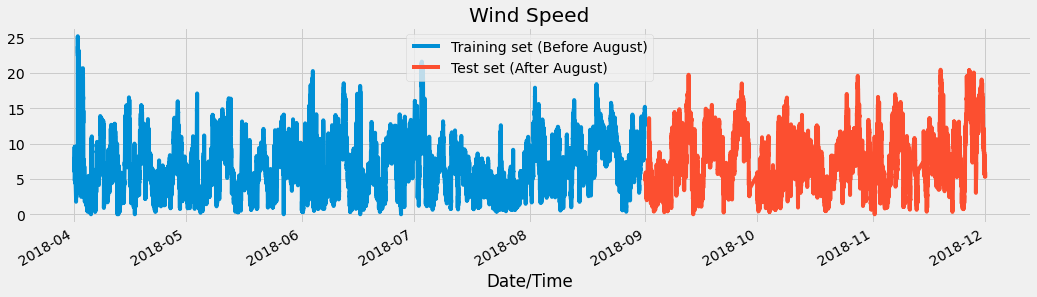

In [23]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
training_set.plot(figsize=(16,4),legend=True)
test_set.plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before August)','Test set (After August)'])
plt.title('Wind Speed')
plt.show()

In [6]:
# Scaling the training set(normalizing it)
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# For each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(288,21862):
    X_train.append(training_set_scaled[i-288:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [10]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
675/675 [==============================] - 317s 469ms/step - loss: 0.0053
Epoch 2/5
675/675 [==============================] - 295s 437ms/step - loss: 0.0022
Epoch 3/5
675/675 [==============================] - 302s 448ms/step - loss: 0.0017
Epoch 4/5
675/675 [==============================] - 392s 581ms/step - loss: 0.0015
Epoch 5/5
675/675 [==============================] - 343s 509ms/step - loss: 0.0014


In [11]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["Wind Speed (m/s)"]['2018-04':'2018-08'],dataset["Wind Speed (m/s)"]['2018-09':'2018-11']),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 288:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [12]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(288,11882):
    X_test.append(inputs[i-288:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

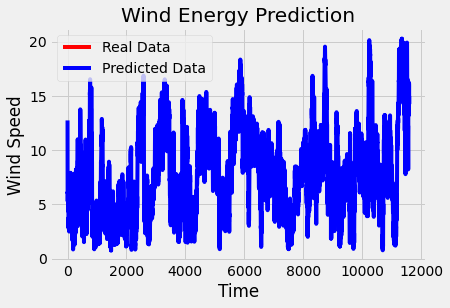

In [21]:
# Visualizing the results for LSTM
plot_predictions(test_set[11882-288],predicted_stock_price)

In [15]:
return_rmse(test_set[:11882-288],predicted_stock_price)

The root mean squared error is 0.8121261430785289.


In [25]:
def smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) +       np.abs(y_true))))

In [82]:
train_ar = training_set.values
test_ar = test_set.values
    
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    print(t,"/",len(test_ar),)
error = mean_squared_error(testset, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape(testset, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
0 / 12387
1 / 12387
2 / 12387


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (12387,) and (173, 1)

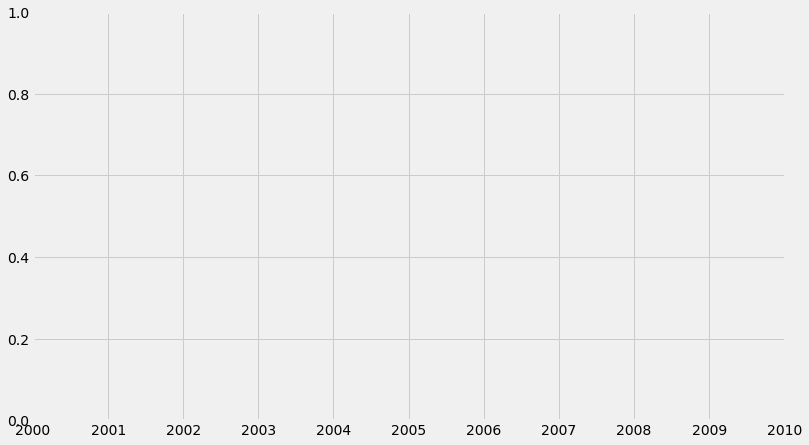

In [80]:
plt.figure(figsize=(12,7))
plt.plot(test_set.index, test_set, color='blue', label='Actual Price')
plt.plot(test_set.index, predictions, color='red', marker='o',label='Predicted Price')

plt.legend()
plt.title('Wind speed')
plt.xlabel('Dates')
plt.ylabel('Wind speed')
#plt.xticks(np.arange(6386,7982, 30), df['Date'][6386:7982:300])
plt.legend()